# TaRGET Project CC RNA-seq Sample Principal Component Analysis

__Author:__ Bryan Quach  
__Date:__ March 13, 2017

## Objective

### Estimated Analysis Time: <1 day*

Using single-end RNA-seq data from the TaRGET project Collaborative Cross (CC) mice, the goal of this analysis is to perform PCA and visually note characteristics of the samples that strongly contribute to variation in the data.

**This estimate optimistically assumes that the analysis will be done as shown below without interruption, with an internet connection with high speed data transfer rates, and with all necessary software already installed. Limitations in internet data transfer rates and software installation can significantly increase analysis time.*

## Analysis Outline

The analysis can be roughly divided into the following steps:

* Data retrieval and wrangling
* Count matrix generation and normalization
* Principal Component Analysis

## R Packages

In addition to the base packages, we use the following R packages in this analysis:

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [tximport](http://bioconductor.org/packages/release/bioc/html/tximport.html)

## Data retrieval and wrangling

In [1]:
#Create data directories and retrieve all gene expression quantification files
system("mkdir data")
system("mkdir data/tamu") #TAMU subdirectory
system("mkdir data/tamu_htsf") #Merged data from TAMU and HTSF subdirectory
system("scp kure.unc.edu:/proj/fureylab/data/RNA-seq/mouse/CC/CC*/*/*genes.results data/")

In [2]:
#Rename TAMU-related files and move them to a subdirectory
move.cmds <- c(
    "mv data/Rusyn-Lung-133.genes.results data/tamu/LUNG_CC133-BD_study_1500ppm_LUNG_CC_133.genes.results",
    "mv data/Rusyn-Lung-50.genes.results data/tamu/LUNG_CC50-BD_study_1500ppm_LUNG_CC_50.genes.results",
    "mv data/Rusyn-Lung-40.genes.results data/tamu/LUNG_CC40-BD_study_625ppm_LUNG_CC_40.genes.results",
    "mv data/Rusyn-Lung-65.genes.results data/tamu/LUNG_CC65-BD_study_1500ppm_LUNG_CC_65.genes.results",
    "mv data/Rusyn-Lung-57.genes.results data/tamu/LUNG_CC57-BD_study_1500ppm_LUNG_CC_57.genes.results",
    "mv data/Rusyn-Lung-33.genes.results data/tamu/LUNG_CC33-BD_study_625ppm_LUNG_CC_33.genes.results",
    "mv data/Rusyn-Lung-117.genes.results data/tamu/LUNG_CC117-BD_study_625ppm_LUNG_CC_117.genes.results",
    "mv data/Rusyn-Lung-19.genes.results data/tamu/LUNG_CC19-BD_study_0ppm_LUNG_CC_19.genes.results",
    "mv data/Rusyn-Lung-72.genes.results data/tamu/LUNG_CC72-BD_study_1500ppm_LUNG_CC_72.genes.results",
    "mv data/Rusyn-Lung-32.genes.results data/tamu/LUNG_CC32-BD_study_625ppm_LUNG_CC_32.genes.results",
    "mv data/Rusyn-Lung-76.genes.results data/tamu/LUNG_CC76-BD_study_0ppm_LUNG_CC_76.genes.results",
    "mv data/Rusyn-Lung-75.genes.results data/tamu/LUNG_CC75-BD_study_0ppm_LUNG_CC_75.genes.results",
    "mv data/Rusyn-Lung-119.genes.results data/tamu/LUNG_CC119-BD_study_625ppm_LUNG_CC_119.genes.results",
    "mv data/Rusyn-Liver-34.genes.results data/tamu/LIVER_CC34-BD_study_625ppm_LIVER_CC_34.genes.results",
    "mv data/Rusyn-Kidney-90.genes.results data/tamu/KIDNEY_CC90-BD_study_0ppm_KIDNEY_CC_90.genes.results",
    "mv data/Rusyn-Kidney-41.genes.results data/tamu/KIDNEY_CC41-BD_study_625ppm_KIDNEY_CC_41.genes.results",
    "mv data/Rusyn-Kidney-120.genes.results data/tamu/KIDNEY_CC120-BD_study_625ppm_KIDNEY_CC_120.genes.results",
    "mv data/Rusyn-Kidney-124.genes.results data/tamu/KIDNEY_CC124-BD_study_625ppm_KIDNEY_CC_124.genes.results",
    "mv data/Rusyn-Kidney-123.genes.results data/tamu/KIDNEY_CC123-BD_study_625ppm_KIDNEY_CC_123.genes.results")

for(cmd in move.cmds){ system(cmd) }

#Rename merged file and move it into a subdirectory
system("mv data/LUNG_CC37-BD_study_625ppm_LUNG_CC_37_htsf_tamu_merged.genes.results data/tamu_htsf/LUNG_CC37-BD_study_625ppm_LUNG_CC_37.genes.results")

#Rename all files to be more concise
files <- list.files("data/", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/", prefix, "_htsf.genes.results", sep="")
    cmd <- paste("mv", paste("data/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

files <- list.files("data/tamu", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/tamu/", prefix, "_tamu.genes.results", sep="")
    cmd <- paste("mv", paste("data/tamu/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

file="LUNG_CC37-BD_study_625ppm_LUNG_CC_37.genes.results"
name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
prefix <- paste(name.data, sep="", collapse="_")
new.file <- paste("data/tamu_htsf/", prefix, "_merged.genes.results", sep="")
cmd <- paste("mv", paste("data/tamu_htsf/", file, sep=""), new.file, sep=" ")
system(cmd)

## Count matrix generation and normalization

In order to perform PCA, we need to produce a matrix of counts where each row is a gene and each column is a sample. Since we are doing multiple PCA analyses, we will be creating and normalizing several matrices that will be used to investigate the following:

* Are all the samples grouping by tissue based on gene expression profiles?
* Do we see a difference within tissue between exposure groups based on gene expression profiles?

The reason for multiple matrices is that we want to normalize the subsets of the data independently for each of the analyses in case a subset of samples unrelated to a particular analysis has an overpowering effect on the normalization.

In [1]:
library(DESeq2)
library(tximport)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are maske

In [2]:
#Prepare file list
files.htsf <- file.path("data", list.files("data/", pattern="genes.results"))
files.tamu <- file.path("data", "tamu", list.files("data/tamu", pattern="genes.results"))
file.merged <- file.path("data", "tamu_htsf", list.files("data/tamu_htsf", pattern="genes.results"))
names(files.htsf) <- basename(sapply(strsplit(files.htsf, '.', fixed=T), function(x){x[1]}))
names(files.tamu) <- basename(sapply(strsplit(files.tamu, '.', fixed=T), function(x){x[1]}))
names(file.merged) <- basename(sapply(strsplit(file.merged, '.', fixed=T), function(x){x[1]}))

#Import data. The abundance values are acquired from the FPKM column by default with type="rsem"
txi.rsem.htsf <- tximport(files.htsf, txIn=F, type = "rsem")
txi.rsem.tamu <- tximport(files.tamu, txIn=F, type = "rsem")
txi.rsem.merged <- tximport(file.merged, txIn=F, type = "rsem")

save(list=c("txi.rsem.htsf","txi.rsem.tamu","txi.rsem.merged"), file="count_data.original.Rdata")

reading in files
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273

Once these data are imported into your R environment, they need to be filtered and normalized. Doing so requires the creation of a `DESeqDataSet` object. To create this object we need count matrix associated sample information and a design formula. The sample information we include is simply sequencing center.

Our count matrices with our `DESeqDataSet` objects are put through a filtering process to remove the rows that have no or nearly no information about the amount of gene expression. As a simple filtering we apply the following rule: removing rows of the `DESeqDataSet` that have no counts or only a single count across all samples. This filtering helps to reduce the contribution of extremely lowly expressed or uninformative genes to the results of PCA. We also incorporate sequencing center into our design formula to remove any variation due to that during normalization.

In [46]:
load("count_data.original.Rdata") #optional unless you are starting the analysis from here

#Create count matrices
cts.htsf <- txi.rsem.htsf$counts
cts.tamu <- txi.rsem.tamu$counts
cts.merged <- txi.rsem.merged$counts
all.cts <- as.matrix(cbind(cts.htsf, cts.tamu, cts.merged)) #combine data

storage.mode(all.cts) <- "integer" #coerce values to integer type
kidney.cts <- all.cts[,grepl(colnames(all.cts), pattern="kidney", ignore.case=T)]
liver.cts <- all.cts[,grepl(colnames(all.cts), pattern="liver", ignore.case=T)]
lung.cts <- all.cts[,grepl(colnames(all.cts), pattern="lung", ignore.case=T)]

#Load sequencing center info
sample.info = DataFrame(rep(NA, length(colnames(all.cts))), row.names=colnames(all.cts))
sample.info[grepl(rownames(sample.info), pattern="htsf"),] <- "HTSF"
sample.info[grepl(rownames(sample.info), pattern="tamu"),] <- "TAMU"
sample.info[grepl(rownames(sample.info), pattern="merged"),] <- "MERGED"
colnames(sample.info) <- "batch"
kidney.info <- subset(x=sample.info, subset=grepl(rownames(sample.info), pattern="kidney", ignore.case=T))
liver.info <- subset(x=sample.info, subset=grepl(rownames(sample.info), pattern="liver", ignore.case=T))
lung.info <- subset(x=sample.info, subset=grepl(rownames(sample.info), pattern="lung", ignore.case=T))


#Create DESeqDataSet objects and apply gene filtering
dds.all <- DESeqDataSetFromMatrix(all.cts, sample.info, ~batch)
dds.kidney <- DESeqDataSetFromMatrix(kidney.cts, kidney.info, ~batch)
dds.liver <- DESeqDataSetFromMatrix(liver.cts, liver.info, ~batch)
dds.lung <- DESeqDataSetFromMatrix(lung.cts, lung.info, ~batch)

dds.kidney <- dds.kidney[rowSums(counts(dds.kidney))>1,]
dds.liver <- dds.liver[rowSums(counts(dds.liver))>1,]
dds.lung <- dds.lung[rowSums(counts(dds.lung))>1,]
dds.all <- dds.all[rowSums(counts(dds.all))>1,]

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

The data transformation we apply is a [variance-stabilizing transformation](https://en.wikipedia.org/wiki/Variance-stabilizing_transformation) implemented with the DESeq2 `vst` function. It uses a subset of the genes instead of the full set to provide computational speed-ups. We specify that 10000 genes be used to estimate the appropriate transformation function. Once the transformations complete, we save the transformed count matrices to an Rdata file.

In [47]:
#Apply Variance Stabilizing Transformation
print("Applying transformations...")
start <- proc.time()
dds.kidney.vst <- vst(dds.kidney, nsub=10000)
proc.time() - start
start <- proc.time()
dds.liver.vst <- vst(dds.liver, nsub=10000)
proc.time() - start
start <- proc.time()
dds.lung.vst <- vst(dds.lung, nsub=10000)
proc.time() - start
start <- proc.time()
dds.all.vst <- vst(dds.all, nsub=10000)
proc.time() - start

#Get transformed count matrices
vst.kidney <- assay(dds.kidney.vst)
vst.liver <- assay(dds.liver.vst)
vst.lung <- assay(dds.lung.vst)
vst.all <- assay(dds.all.vst)

save(list=c("vst.kidney", 
            "vst.liver", 
            "vst.lung", 
            "vst.all"), 
     file="count_data.transformed.Rdata")


[1] "Applying transformations..."


   user  system elapsed 
 17.936   0.064  18.005 

   user  system elapsed 
 17.988   0.000  17.985 

   user  system elapsed 
 18.092   0.012  18.106 

   user  system elapsed 
144.572   0.452 145.049 

## Principal Component Analysis and Clustering

We will generate several PCA plots to visually explore questions we have about the data. As a reminder, these questions are:

* Are all the samples grouping by tissue based on gene expression profiles?
* Do we see a difference within tissue between exposure groups based on gene expression profiles?

To visually explore both of these questions, we will assign geometric or color labels to aid in the comparison of groups.

### Are all the samples grouping by tissue?

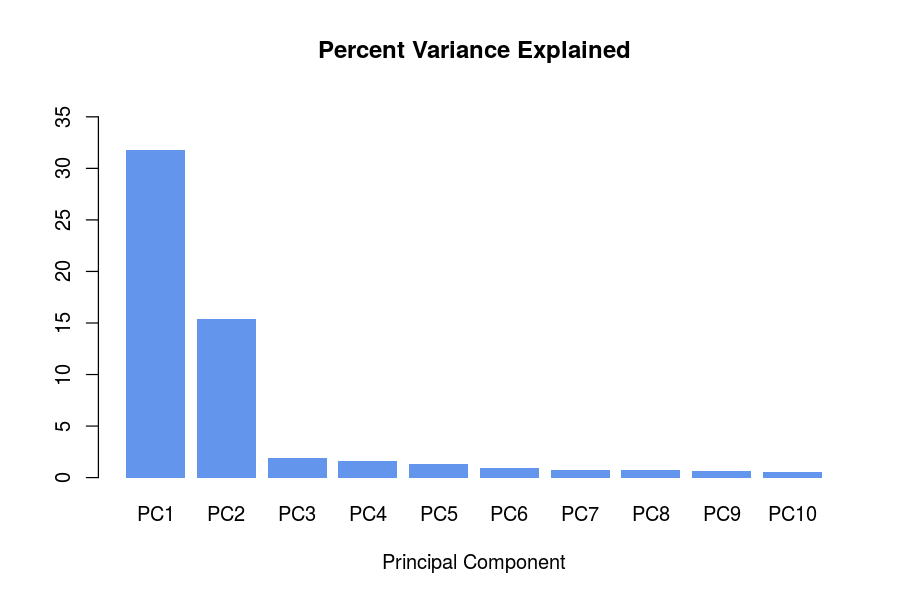

In [48]:
load("count_data.transformed.Rdata") #optional unless you are starting the analysis from here

#Run PCA and get % variance
pca.results <- prcomp(t(vst.all), center=T, scale.=T)
dspace <- pca.results$x #transformed dataspace

#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=5)

#Percent of Variance Explained for PCs 1-10
pca.var <- summary(pca.results)
barplot(pca.var$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var$importance[2,1:10]*100)+5))


Based on the truncated scree plot above, PCs 1 and 2 account for most of the variance in the data, so we will look at those PCs. We will also include PC 3 for good measure.

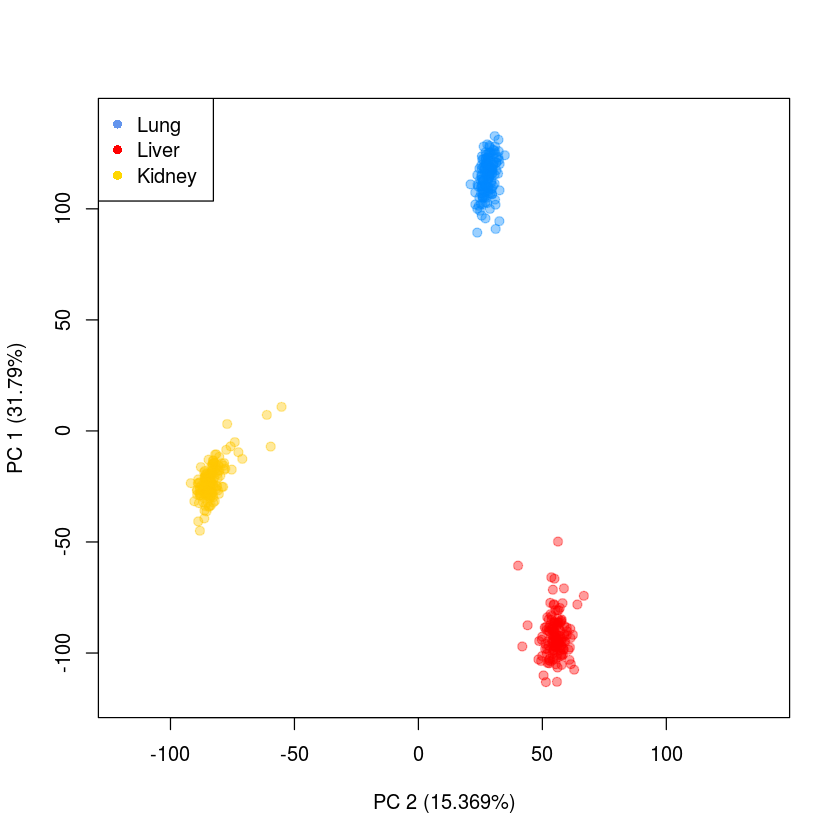

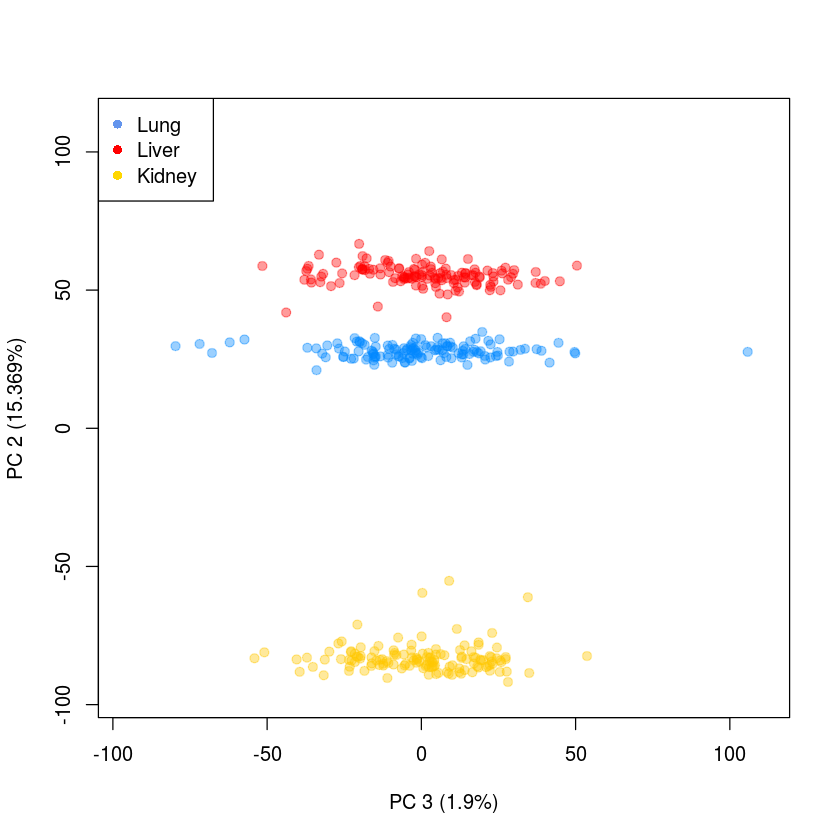

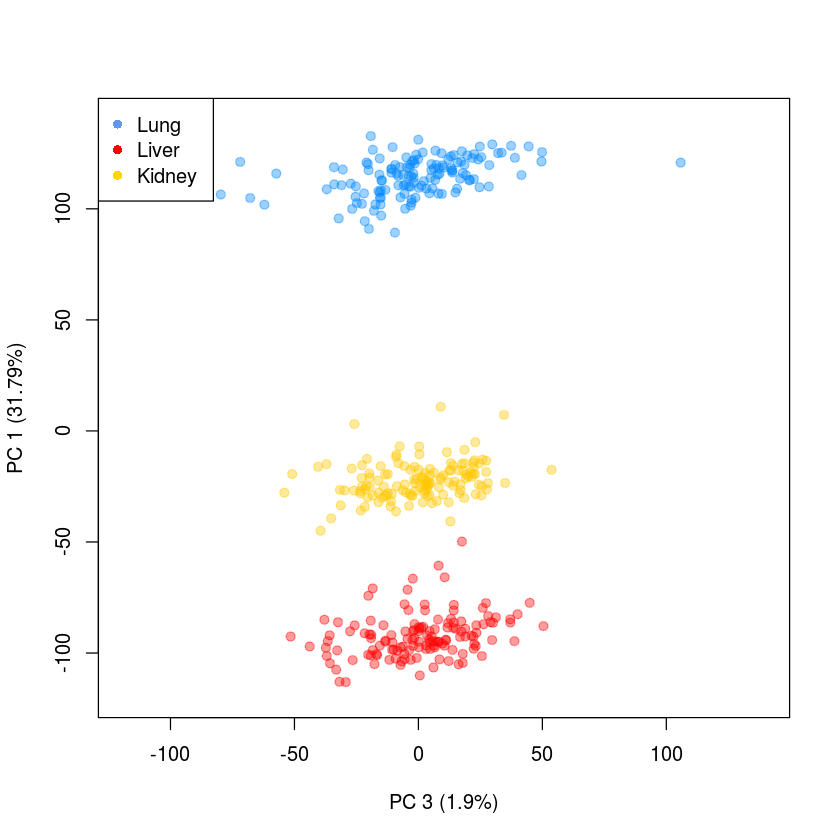

In [50]:
#Define plot properties
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
pc3.pov <- pca.var$importance[2,3]*100
options(repr.plot.width=7, repr.plot.height=7)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
lung <- grepl("LUNG", sample.names, fixed=T)
kidney <- grepl("KIDNEY", sample.names, fixed=T)
liver <- grepl("LIVER", sample.names, fixed=T)
colors[which(lung)] <- rgb(0,136,255,100, maxColorValue=255) #lightblue
colors[which(liver)] <- rgb(255,0,0,100, maxColorValue=255) #red
colors[which(kidney)] <-  rgb(255,200,0,100, maxColorValue=255) #gold
scale = 1.05
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
plot.lim2 = c(min(dspace[,3], dspace[,2])*scale, max(dspace[,3], dspace[,2])*scale)
plot.lim3 = c(min(dspace[,1], dspace[,3])*scale, max(dspace[,1], dspace[,3])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
legend.col = c("cornflowerblue", "red", "gold")
legend.lab = c("Lung", "Liver", "Kidney")

#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=21, col=colors, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

#PC2 vs PC3
plot(y=dspace[,2], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label)
legend("topleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA)

#PC1 vs PC3
plot(y=dspace[,1], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

The above PCA plots show tissue specific gene expression profiles generate the most variability between samples.

### Do we see a differences between exposure groups within tissue?

If there are consistent drastic trends in gene expression profile changes between treatment groups, we would expect these to be noticeable by PCA. The plots below assess this expectation.

In [51]:
#Run PCA and get % variance
pca.results.liver <- prcomp(t(vst.liver), center=T, scale.=T)
pca.results.lung <- prcomp(t(vst.lung), center=T, scale.=T)
pca.results.kidney <- prcomp(t(vst.kidney), center=T, scale.=T)
dspace.liver <- pca.results.liver$x #transformed dataspace
dspace.lung <- pca.results.lung$x #transformed dataspace
dspace.kidney <- pca.results.kidney$x #transformed dataspace

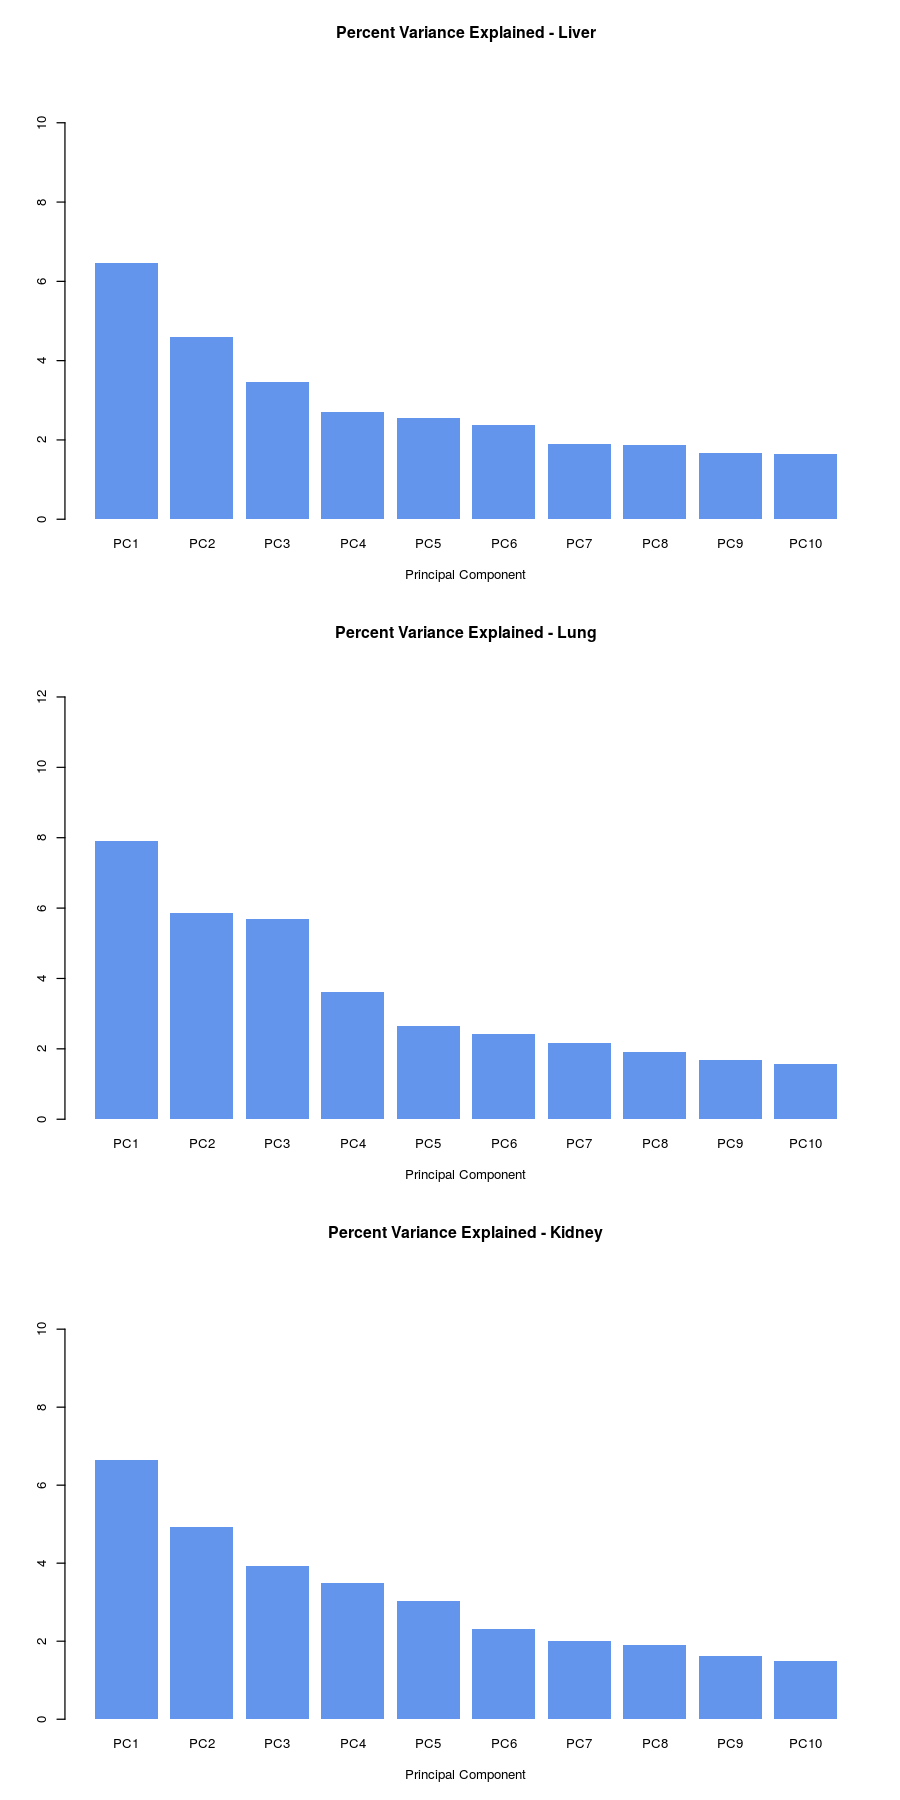

In [54]:
#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=15)

#Percent of Variance Explained for PCs 1-10
par(mfrow=c(3,1))
pca.var.liver <- summary(pca.results.liver)
pca.var.lung <- summary(pca.results.lung)
pca.var.kidney <- summary(pca.results.kidney)
barplot(pca.var.liver$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Liver", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.liver$importance[2,1:10]*100)+5))
barplot(pca.var.lung$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Lung", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.lung$importance[2,1:10]*100)+5))
barplot(pca.var.kidney$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Kidney", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.kidney$importance[2,1:10]*100)+5))

In the truncated scree plots above, the reduction in variance explained with each additional PC is not as drastic as in previous analyses, so we will explore up to PC5.

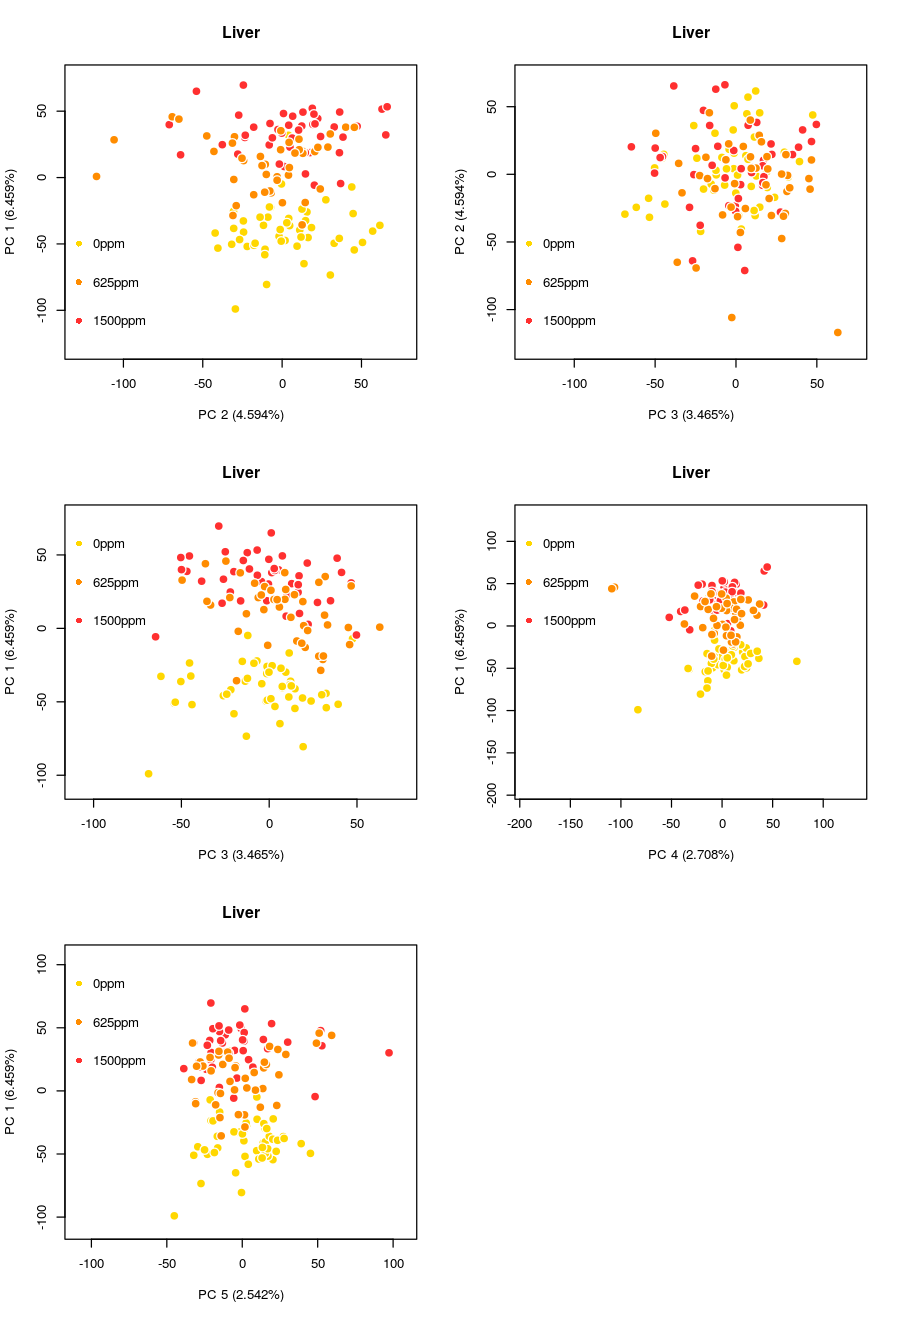

In [55]:
#PCA plots for liver tissue

#Define plot properties
pc1.pov <- pca.var.liver$importance[2,1]*100
pc2.pov <- pca.var.liver$importance[2,2]*100
pc3.pov <- pca.var.liver$importance[2,3]*100
pc4.pov <- pca.var.liver$importance[2,4]*100
pc5.pov <- pca.var.liver$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.liver)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.liver[,1], dspace.liver[,2])*scale, max(dspace.liver[,1], dspace.liver[,2])*scale)
plot.lim2 = c(min(dspace.liver[,3], dspace.liver[,2])*scale, max(dspace.liver[,3], dspace.liver[,2])*scale)
plot.lim3 = c(min(dspace.liver[,1], dspace.liver[,3])*scale, max(dspace.liver[,1], dspace.liver[,3])*scale)
plot.lim4 = c(min(dspace.liver[,1], dspace.liver[,4])*scale*1.6, max(dspace.liver[,1], dspace.liver[,4])*scale*1.6)
plot.lim5 = c(min(dspace.liver[,1], dspace.liver[,5])*scale, max(dspace.liver[,1], dspace.liver[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.liver[,1], x=dspace.liver[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.liver[,2], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.liver[,1], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC4
plot(y=dspace.liver[,1], x=dspace.liver[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc1.label, xlab=pc4.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC5
plot(y=dspace.liver[,1], x=dspace.liver[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc1.label, xlab=pc5.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")



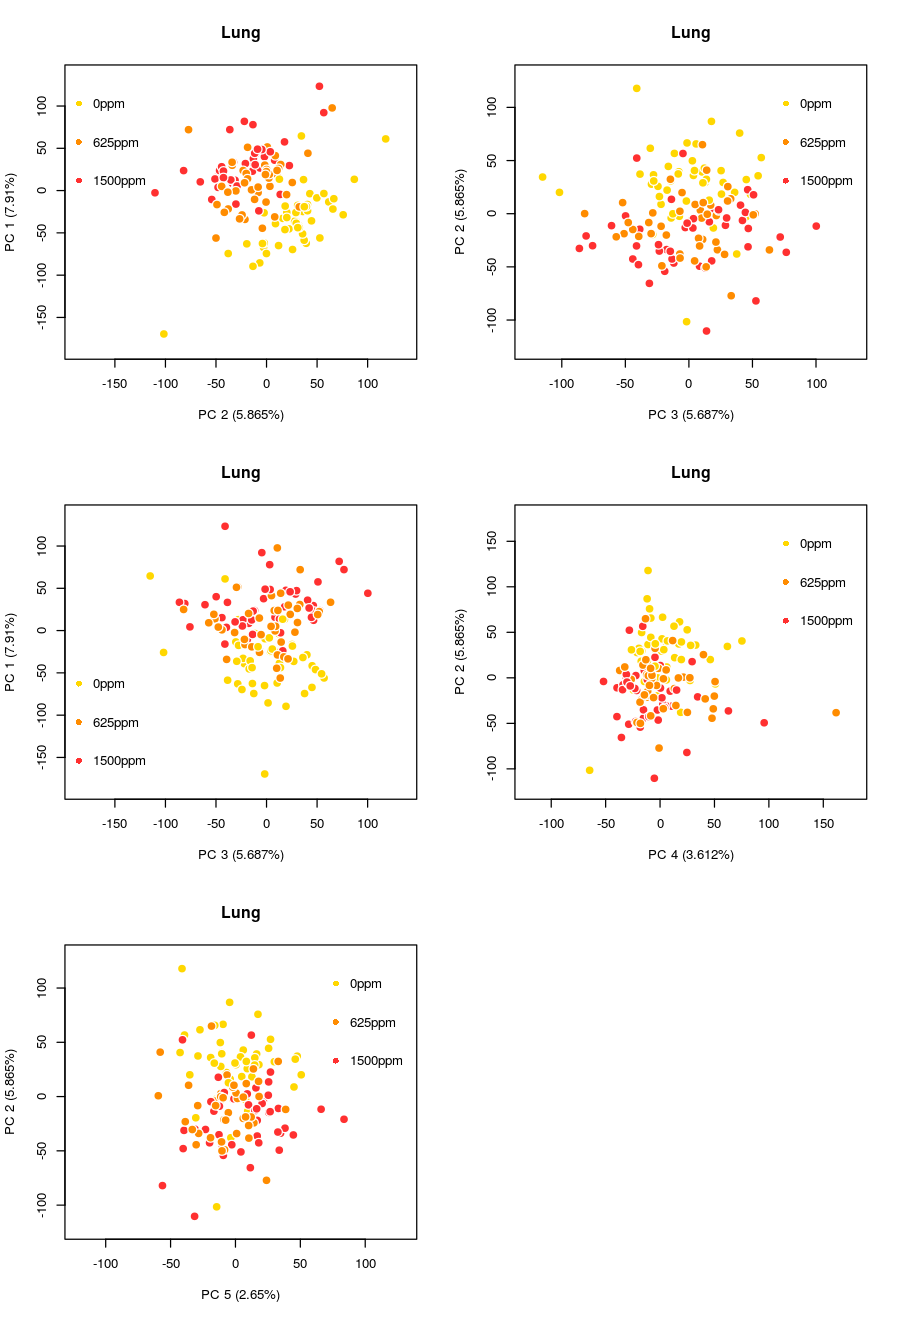

In [61]:
#PCA plots for lung tissue

#Define plot properties
pc1.pov <- pca.var.lung$importance[2,1]*100
pc2.pov <- pca.var.lung$importance[2,2]*100
pc3.pov <- pca.var.lung$importance[2,3]*100
pc4.pov <- pca.var.lung$importance[2,4]*100
pc5.pov <- pca.var.lung$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.lung)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.lung[,1], dspace.lung[,2])*scale, max(dspace.lung[,1], dspace.lung[,2])*scale)
plot.lim2 = c(min(dspace.lung[,3], dspace.lung[,2])*scale, max(dspace.lung[,3], dspace.lung[,2])*scale)
plot.lim3 = c(min(dspace.lung[,1], dspace.lung[,3])*scale, max(dspace.lung[,1], dspace.lung[,3])*scale)
plot.lim4 = c(min(dspace.lung[,2], dspace.lung[,4])*scale, max(dspace.lung[,2], dspace.lung[,4])*scale)
plot.lim5 = c(min(dspace.lung[,2], dspace.lung[,5])*scale, max(dspace.lung[,2], dspace.lung[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.lung[,1], x=dspace.lung[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Lung")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.lung[,2], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("topright",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.lung[,1], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.lung[,2], x=dspace.lung[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.lung[,2], x=dspace.lung[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")


PC 4 Outlier: KIDNEY_625ppm_117_htsf

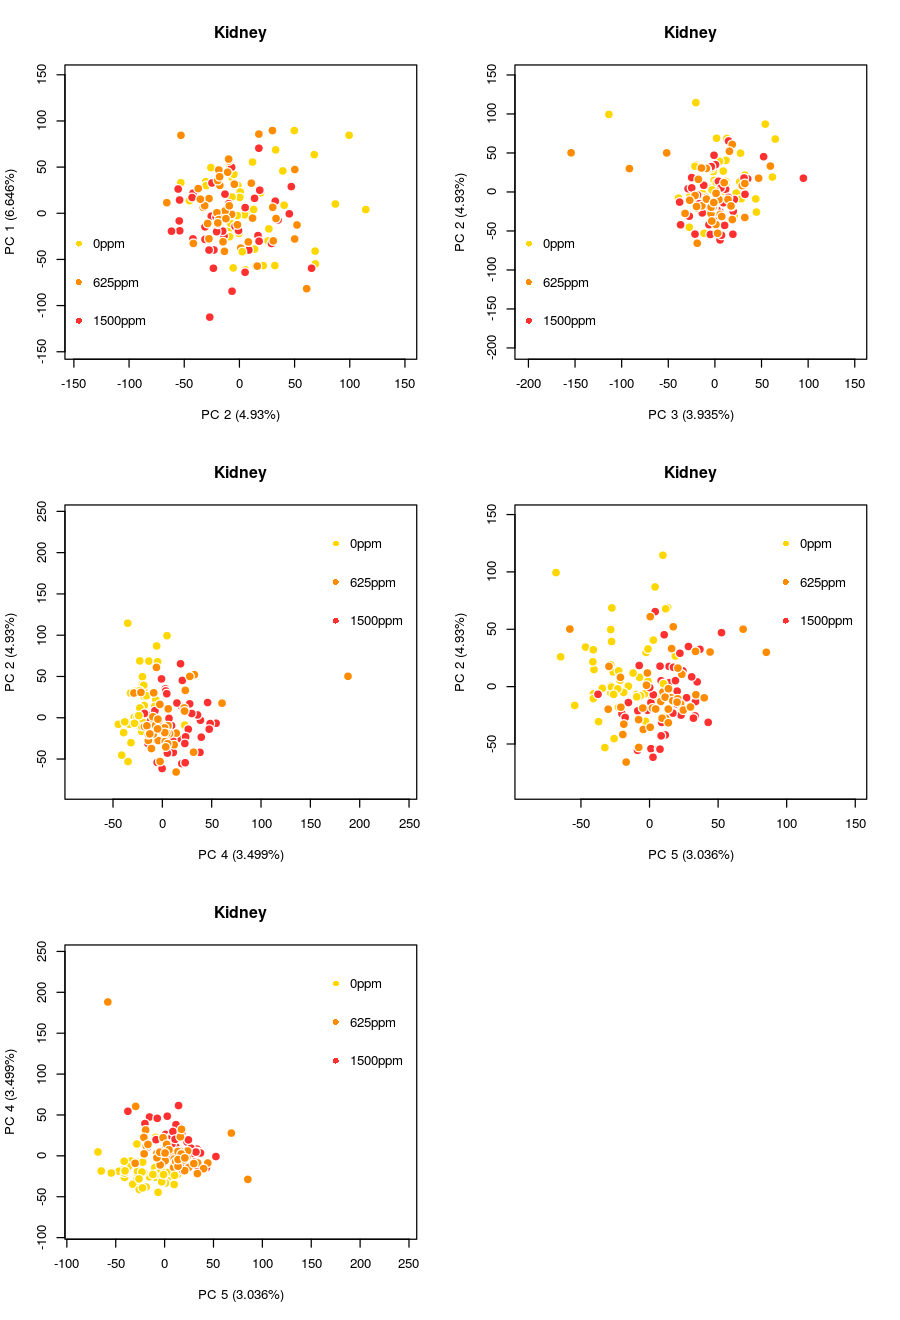

In [72]:
#PCA plots for kidney tissue

#Define plot properties
pc1.pov <- pca.var.kidney$importance[2,1]*100
pc2.pov <- pca.var.kidney$importance[2,2]*100
pc3.pov <- pca.var.kidney$importance[2,3]*100
pc4.pov <- pca.var.kidney$importance[2,4]*100
pc5.pov <- pca.var.kidney$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.kidney)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.3
plot.lim1 = c(min(dspace.kidney[,1], dspace.kidney[,2])*scale, max(dspace.kidney[,1], dspace.kidney[,2])*scale)
plot.lim2 = c(min(dspace.kidney[,3], dspace.kidney[,2])*scale, max(dspace.kidney[,3], dspace.kidney[,2])*scale)
plot.lim3 = c(min(dspace.kidney[,2], dspace.kidney[,4])*scale, max(dspace.kidney[,2], dspace.kidney[,4])*scale)
plot.lim4 = c(min(dspace.kidney[,2], dspace.kidney[,5])*scale, max(dspace.kidney[,2], dspace.kidney[,5])*scale)
plot.lim5 = c(min(dspace.kidney[,4], dspace.kidney[,5])*scale, max(dspace.kidney[,4], dspace.kidney[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.kidney[,1], x=dspace.kidney[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.kidney[,2], x=dspace.kidney[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.kidney[,2], x=dspace.kidney[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.kidney[,2], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC4 vs PC5
plot(y=dspace.kidney[,4], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc4.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#Show PC 4 outlier
cat("PC 4 Outlier:", sample.names[which(dspace.kidney[,4]>150)])

There appears to be an outlier sample in PC 4, KIDNEY_625ppm_117_htsf.